In [13]:
import imp 

import os
import sys

import networkx as nx
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString,Point
import numpy as np


import matplotlib.pyplot as plt
import bokeh as bh

from datetime import datetime

%load_ext autoreload
%autoreload 2
import taxi_driver.taxi_driver as td

import plotly.express as px

import sklearn.metrics as skm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
#setting some much needed paths 

dataPath = os.path.join("data")
csvPath  = os.path.join(dataPath,"CSV")
shpPath  = os.path.join(dataPath,"SHP")

outputPath = os.path.join("outputs")
imagePath = os.path.join(outputPath,"images")



In [120]:
zoneShpPath = os.path.join(shpPath,"taxi_zones.shp")

#combine in one
# march_path = os.path.join(csvPath,"march_data.csv")
# june_path = os.path.join(csvPath,"june_data.csv")
# nov_path = os.path.join(csvPath,"november_data.csv")

# taxi_df=td.Taxidf([march_path,june_path,nov_path],sample_fraction=0.2,taxi_zones_shp_path=zoneShpPath)
#taxi_df.convert_dates()

#save the combined sample df
# csv_sample_path = os.path.join(csvPath,"sample_csv.csv")
# taxi_df.taxi_data.to_csv(csv_sample_path)
#---------------------------------------------------

#load the sample
csv_sample_path = os.path.join(csvPath,"sample_csv.csv")
taxi_df=td.Taxidf(csv_sample_path,taxi_zones_shp_path=zoneShpPath)
taxi_df.convert_dates()

In [5]:
#remove the abnormal dates
taxi_df.taxi_data=taxi_df.taxi_data.loc[taxi_df.taxi_data['pu_month'].isin([3,6,11])]


#will remove the day of the storm 
remove_dates=["2017-03-14","2017-06-25","2017-11-23","2017-11-24","2017-11-25","2017-11-26"]

for rd in remove_dates:
    sample_df = taxi_df.taxi_data[taxi_df.taxi_data['pu_date']!=rd]
    sample_df = sample_df[sample_df['do_date']!=rd]
    taxi_df.taxi_data = sample_df

In [37]:
sample_df=taxi_df.taxi_data.copy()

#will keep only the payment checks
clean_df = sample_df[sample_df['payment_type']==1]

# I will create a sample of only the non_negative
clean_df= clean_df[clean_df['tip_amount']>=0]
clean_df= clean_df[clean_df['trip_distance']>=0]

#controlling the value between >0 and 2000$
clean_df=clean_df.loc[(clean_df['fare_amount']>0) & (clean_df['fare_amount']<2000)]


Introduce some new features that might help on the modelling

In [7]:
import holidays
us_holidays = holidays.UnitedStates()
grouped_date=taxi_df.grouped_date()
holidays=[datetime.strptime(i,"%Y-%m-%d") in grouped_date for i in list (grouped_date.index)] 

if(not True in holidays):
    print("there are no holidays in the data set")
else:
    print("check for the holidays")

there are no holidays in the data set


In [38]:
clean_df['dollar_per_mile']=clean_df['fare_amount']/clean_df['trip_distance']
clean_df['tip_to_fare']=clean_df['tip_amount']/clean_df['fare_amount']
clean_df['duration_s']=(clean_df['tpep_dropoff_datetime']-clean_df['tpep_pickup_datetime']).apply(lambda x:x.seconds)

In [39]:
clean_df=clean_df[clean_df['tip_to_fare']<1]

In [40]:

corr = clean_df[["tip_amount",'passenger_count',"trip_distance","fare_amount","duration_s"]].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,tip_amount,trip_distance,fare_amount,duration_s
tip_amount,1.00,0.78,0.81,0.16
trip_distance,0.78,1.00,0.90,0.19
fare_amount,0.81,0.90,1.00,0.20
duration_s,0.16,0.19,0.20,1.00


My first intuition looking the highly correlated values of tip amount and fare_amount,trip_distance is to try to fit a linear model on the data and see how it behaves. So first we will create a simple linear regression model that will be our base model. Did a test with fare amount and trip duration but the coefficient for the trip duration was extremly low. 

In [16]:
fileName = "clean_sample.csv"
filePath = os.path.join(csvPath,fileName)
# clean_df.to_csv(filePath)
clean_df_all=pd.read_csv(filePath)

In [23]:
clean_df_all['tip_to_fare']=clean_df_all['tip_to_fare'].round(2)
clean_df_all['dollar_per_mile']=clean_df_all['dollar_per_mile'].round(2)

In [158]:
#split the df two to parts 


part_1_train, part_2_train, part_1_test, part_2_test = train_test_split(clean_df_all[["trip_distance","duration_s","PULocationID","DOLocationID","tip_amount","fare_amount"]],
                                                                    clean_df_all[["trip_distance","duration_s","PULocationID","DOLocationID","tip_amount"]], test_size=0.20, random_state=42)


In [153]:
len(part_2_train)

761645

In [161]:
data_train, data_test, labels_train, labels_test = train_test_split(part_1_train[["fare_amount"]].values,
                                                                    part_1_test['tip_amount'], test_size=0.20, random_state=42)


reg_bm = LinearRegression().fit(data_train, labels_train)


labels_pred = reg_bm.predict(data_test)

# The coefficients
print('Coefficients: \n', reg_bm.coef_)

# The mean squared error
print('Mean squared error: %.2f'% skm.mean_squared_error(labels_test, labels_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% skm.r2_score(labels_test, labels_pred))


Coefficients: 
 [0.1790599]
Mean squared error: 2.26
Coefficient of determination: 0.67


In [79]:
x1,x2=zip(*list(data_test))

In [165]:
labels_zip=list(zip(list(labels_test),list(labels_pred)))
sorted_labels_zip=sorted(labels_zip,key=lambda x:x[1])

labels_test_ordered,labels_test_pred = zip(*sorted_labels_zip)


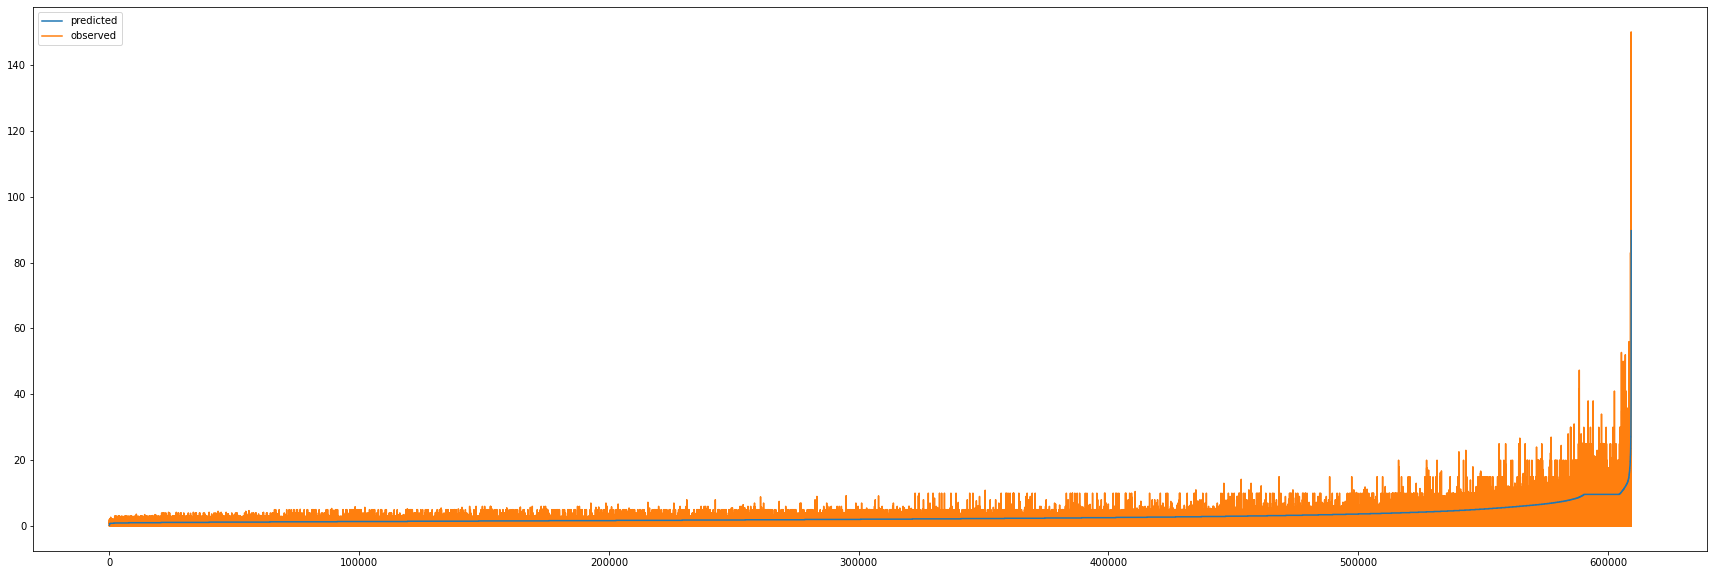

In [166]:
fig,ax = plt.subplots(figsize=(30,10))
ax.plot(labels_test_pred,zorder=100,label="predicted")
ax.plot(labels_test_ordered,label="observed")

plt.legend()

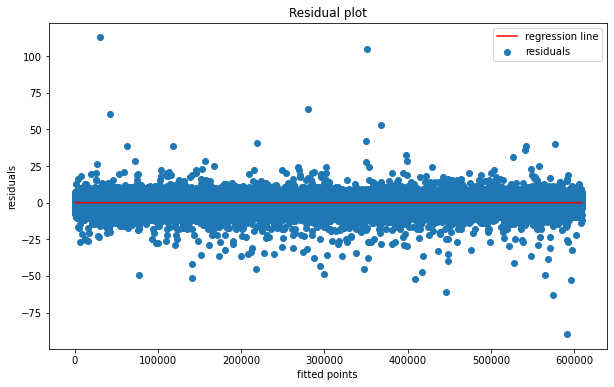

In [167]:
residuals = labels_test - labels_pred

plt.figure(figsize=(10, 6))

f=np.arange(len(residuals))
k = [0 for i in range(len(residuals))]
plt.scatter( f, residuals, label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.legend()




Then I decided to have a take on a spatial approach where I am going to build a model for each of the OD tupples

In [101]:
part_2_train

,trip_distance,duration_s,PULocationID,DOLocationID
165048,18.52,2827,132,234
1997424,0.62,404,237,237
1521747,0.68,398,141,43
2924887,5.70,2113,170,223
410619,3.13,946,144,233
...,...,...,...,...
3132609,0.39,217,162,233
446367,2.03,697,41,239
1047943,4.30,1474,162,231
1029121,0.98,445,75,43


In [168]:
od_tip_data=part_1_train.groupby(["PULocationID","DOLocationID"])['tip_amount'].agg(['mean', 'min', 'max',"count","std"])
od_tip_data.sort_values("count",ascending=False)

mean    min     max  count       std
PULocationID DOLocationID                                           
264          264            2.679818   0.00  100.00  40049  2.601075
237          236            1.443915   0.00   10.55  17141  0.574446
236          237            1.625665   0.00   15.00  13902  0.702481
             236            1.263750   0.00   17.00  13348  0.858442
237          237            1.342556   0.00   25.00  11252  0.993082
...                              ...    ...     ...    ...       ...
216          124            2.760000   2.76    2.76      1       NaN
             117            7.120000   7.12    7.12      1       NaN
             116           11.650000  11.65   11.65      1       NaN
             113           10.000000  10.00   10.00      1       NaN
45           16             0.000000   0.00    0.00      1       NaN

[18790 rows x 5 columns]

In [130]:
od_tip_data.describe()

,mean,min,max,count,std
count,12977.000000,12977.000000,12977.000000,12977.000000,9203.000000
mean,4.622610,2.601925,7.198941,58.691916,1.914312
std,3.505222,3.749774,5.327344,191.651730,1.714249
min,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.365769,0.000000,4.350000,1.000000,0.945449
50%,3.872000,1.000000,6.350000,4.000000,1.446979
75%,5.941000,4.020000,9.050000,27.000000,2.319883
max,105.050000,105.050000,105.050000,10065.000000,37.847849


In [173]:
modeling_sample=od_tip_data[od_tip_data['count']>3000]
print(len(modeling_sample))

182


In [179]:
r2_scores=[]
mse_scores=[]

linear_regression_performance = {}
index_=0
for tupple_ in modeling_sample.index:
    
    
    zone_tupple_df=part_1_train[(part_1_train['PULocationID']==tupple_[0]) & (part_1_train['DOLocationID']==tupple_[1])]


    data_train, data_test, labels_train, labels_test = train_test_split(zone_tupple_df[['trip_distance',"duration_s","tip_amount","fare_amount"]],
                                                            zone_tupple_df['tip_amount'], test_size=0.20, random_state=42)


    reg = LinearRegression().fit(data_train[["fare_amount"]], labels_train)
    labels_pred = reg.predict(data_test[["fare_amount"]])
    mse_score=skm.mean_squared_error(labels_test, labels_pred)
    r2_score_ = skm.r2_score(labels_test, labels_pred)


    #i will also test if the tupple performs better using the bm 
    labels_pred_bm = reg_bm.predict(data_test[["fare_amount"]])
    mse_score_bm=skm.mean_squared_error(labels_test, labels_pred_bm)
    r2_score_bm = skm.r2_score(labels_test, labels_pred_bm) 

    mean_trained = data_train['tip_amount'].mean()
    mean_vals = [ mean_trained for i in range(len(labels_pred_bm))]
    mse_score_mean=skm.mean_squared_error(mean_vals, labels_pred_bm)
    r2_score_mean = skm.r2_score(mean_vals, labels_pred_bm) 


    linear_regression_performance[tupple_]={"mse_score":mse_score,"r2_score":r2_score_,
                                            "local_coef":reg.coef_,"local_intercept":reg.intercept_,
                                            "mse_score_bm":mse_score_bm,"r2_score_bm":r2_score_bm,
                                             "mse_score_mean":mse_score_mean,"r2_score_mean":r2_score_mean}



    
    if(index_%100==0):
        
        print(len(modeling_sample.index)-index_, "left to go..")
        
        
    index_+=1


182 left to go..
82 left to go..


In [132]:
linear_regression_performance

{(13, 231): {'mse_score': 0.3906129748150652,
  'r2_score': 0.08962781238972051,
  'local_coef': array([0.29593402, 0.00097359]),
  'local_intercept': 0.7686580821296851,
  'mse_score_bm': 0.3877269189829632,
  'r2_score_bm': 0.09635412495698736,
  'mse_score_mean': 0.06214340881941659,
  'r2_score_mean': -3.1510451796064673e+29},
 (43, 43): {'mse_score': 1.016585559931867,
  'r2_score': 0.00522686330906974,
  'local_coef': array([ 5.82488074e-01, -1.41290420e-06]),
  'local_intercept': 0.9563034505042516,
  'mse_score_bm': 1.0013234698750122,
  'r2_score_bm': 0.020161481502283474,
  'mse_score_mean': 0.0895031995316785,
  'r2_score_mean': 0.0},
 (43, 142): {'mse_score': 0.5755416009635848,
  'r2_score': 0.11926044711128903,
  'local_coef': array([6.44045256e-01, 1.83126158e-07]),
  'local_intercept': 0.8593229476366433,
  'mse_score_bm': 0.5553040908675914,
  'r2_score_bm': 0.150229495332451,
  'mse_score_mean': 0.1165540116738089,
  'r2_score_mean': -2.626662450796656e+29},
 (43, 161

In [181]:
r2_scores_,mse_scores_,results_=[],[],[]
edge_list_local = []
edge_list_bm =[]
for keys,val in linear_regression_performance.items():
    
    mse_diff=val['mse_score']-val["mse_score_bm"]
    r2_diff = val['r2_score']-val['r2_score_bm']
    
    better_model="mix"
    if((mse_diff<0) and (r2_diff>0)):
        better_model = "local"
        edge_list_local.append(keys)
    elif((mse_diff>0) and (r2_diff<0)):
        better_model="bm"
        edge_list_bm.append(keys)

        
    linear_regression_performance[keys]['better_model']=better_model
    mse_scores_.append(mse_diff)
    r2_scores_.append(r2_diff)
    results_.append(better_model)

In [265]:
pd.Series(results_).value_counts()

local    114
bm        68
dtype: int64

In [122]:
taxi_df.compute_taxi_zones()
taxi_df.graph_representation()
taxi_df.assign_attributes_to_graph(od_tip_data,["mean","min","max","count","std"])



In [183]:
clear_bm_edgelist =[]
for i in edge_list_bm:
    if(i in list(taxi_df.G_main.edges())):
        clear_bm_edgelist.append(i)
        
clear_local_edgelist =[]
for i in edge_list_local:
    if(i in list(taxi_df.G_main.edges())):
        clear_local_edgelist.append(i)

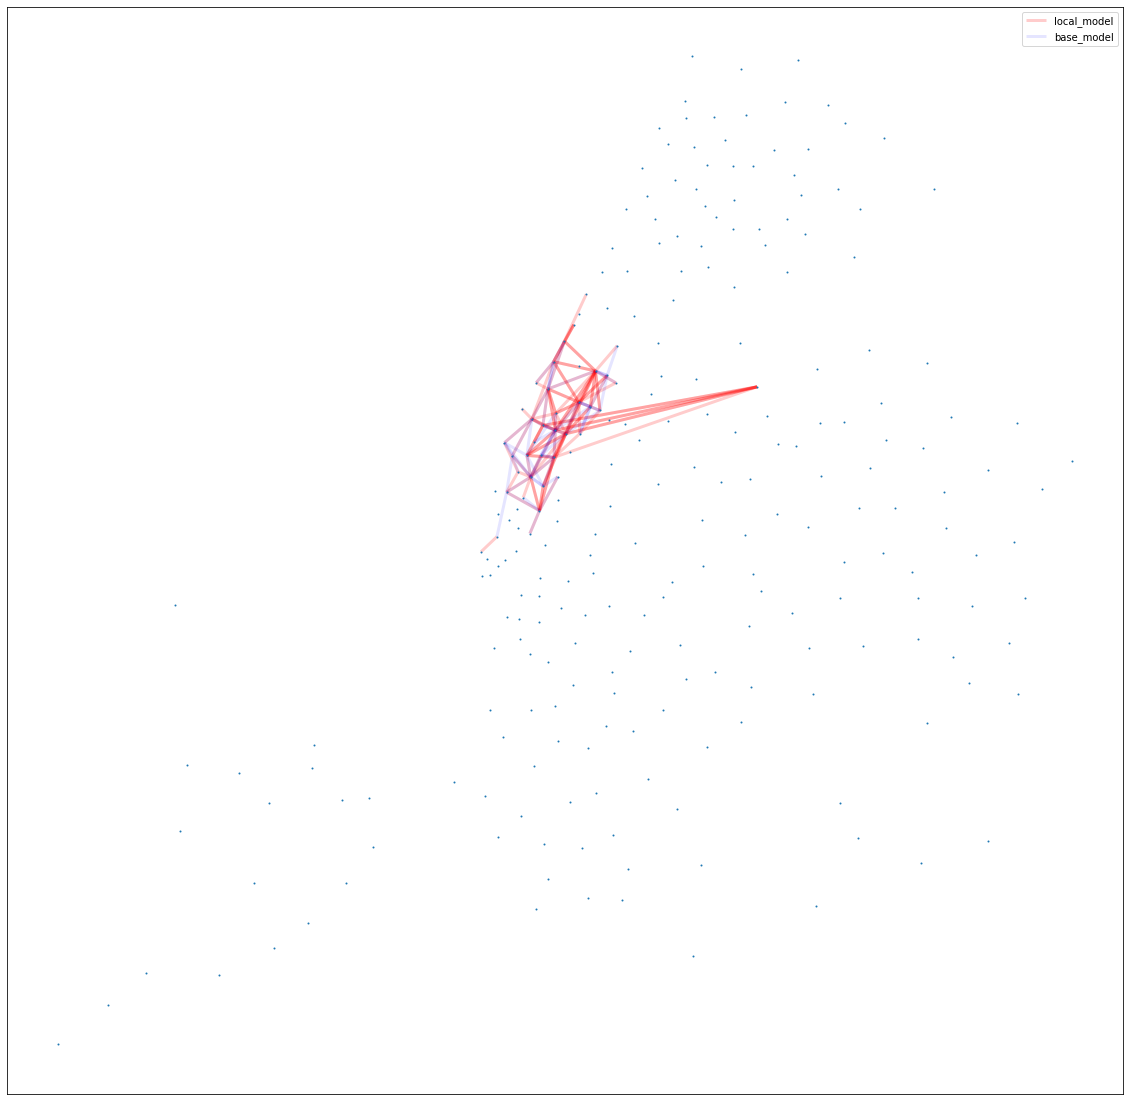

In [184]:
#most of the trips sampled with higher than 7dollar per mile existin in the manhattan area

min_vals=np.array(list(nx.get_edge_attributes(taxi_df.G_main,"std").values()))

        
fig,ax = plt.subplots(figsize=(20,20))
nx.draw_networkx_nodes(taxi_df.G_main,pos=taxi_df.pos,node_size=1,ax=ax)
nx.draw_networkx_edges(taxi_df.G_main,pos=taxi_df.pos,arrows=False,ax=ax,width=3,alpha=0.2,
                       edge_color="red",edgelist=clear_local_edgelist,label="local_model")


nx.draw_networkx_edges(taxi_df.G_main,pos=taxi_df.pos,arrows=False,ax=ax,width=3,alpha=0.1,
                       edge_color="blue",edgelist=clear_bm_edgelist,label="base_model")

plt.legend()

Text(0.5, 1.0, 'R2 scores comparisson')

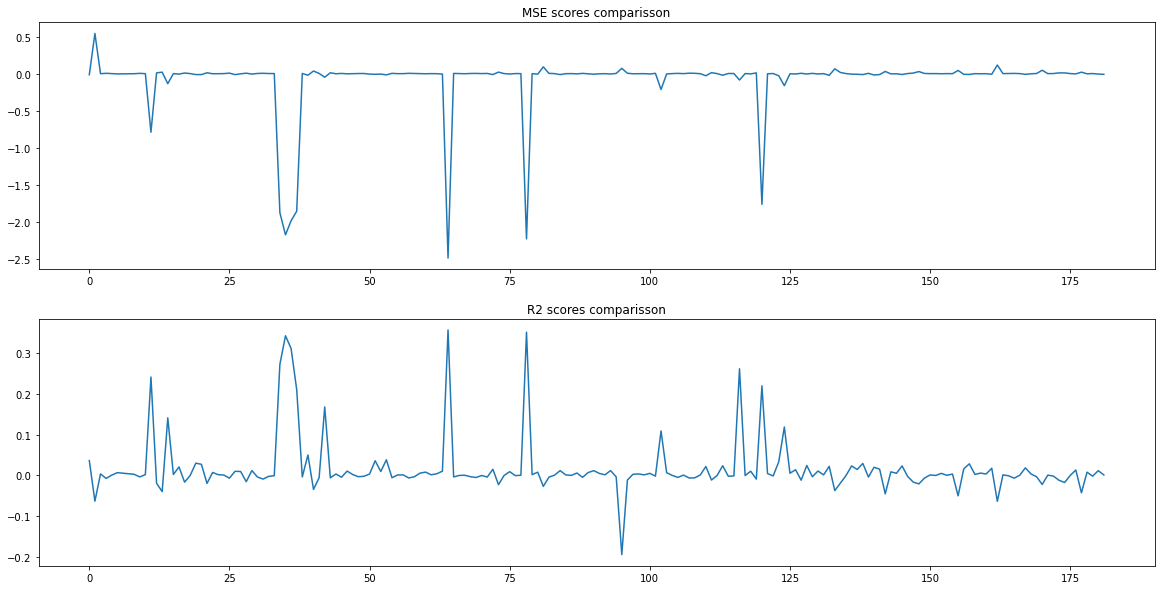

In [185]:
fig,ax = plt.subplots(2,1,figsize=(20,10))

ax[0].plot(mse_scores_)
ax[0].set_title("MSE scores comparisson")

ax[1].plot(r2_scores_)
ax[1].set_title("R2 scores comparisson")


In [267]:
result_df=pd.DataFrame(linear_regression_performance).T
result_df

mse_score  r2_score             local_coef local_intercept  \
13  231  0.317714   0.24375  [0.15714625530568554]        0.427623   
48  48    2.08806  0.757255   [0.1443239814149837]        0.529471   
    50   0.331627  0.234764  [0.18438004213104806]        0.259218   
    68   0.356637  0.305589    [0.135589023407789]        0.626122   
    142  0.310791  0.377076  [0.17441143383369848]        0.365077   
...           ...       ...                    ...             ...   
263 75    0.34422   0.23425  [0.12750075835617478]        0.518991   
    141  0.217122  0.327744  [0.16401100876915714]        0.350848   
    236  0.200325  0.296094  [0.15652097941144474]        0.412911   
    237   0.36034  0.343324  [0.14360955430899025]        0.530845   
264 264   2.83912  0.592254  [0.14284419519575015]        0.763085   

        mse_score_bm r2_score_bm mse_score_mean r2_score_mean better_model  
13  231     0.333089    0.207153       0.239897             0        local  
48  48       1.54614    0.820255         5.2897  -1.07288e+32           bm  
    50      0.333303    0.230896        0.13533             0        local  
    68      0.352936    0.312795       0.192496  -3.90429e+30           bm  
    142     0.311226    0.376204       0.191447    -3.883e+30        local  
...              ...         ...            ...           ...          ...  
263 75      0.325132    0.276713      0.0792659   -1.6077e+30           bm  
    141     0.219745    0.319621       0.125025  -2.53581e+30        local  
    236     0.199858    0.297734      0.0925134             0           bm  
    237     0.366816    0.331522       0.256576             0        local  
264 264      2.84899    0.590837        5.21771             0        local  

[182 rows x 9 columns]

In [276]:
pd.Series(result_df['mse_score'].values).mean()

0.658425381360766

In [187]:
#store the results to a csv 
resultDf=pd.DataFrame(linear_regression_performance).T.reset_index()
resultDf.to_csv("results.csv")

In [188]:
# import pandas as pd

# resultDf=pd.read_csv("results.csv")


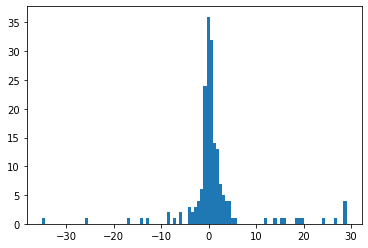

In [189]:
perf=100*(resultDf['mse_score_bm']-resultDf['mse_score'])/resultDf['mse_score_bm']
plt.hist(perf,bins=100)
plt.show()

In [190]:
#some average 
print("Mean MSE", resultDf['mse_score'].mean(), "Mean R2",resultDf['r2_score'].mean())

Mean MSE 0.658425381360766 Mean R2 0.3216422983516764


In [223]:

def local_model_fit(x,attr,bm_model,local_dict):
    
    predictions=[]
    
    for row_ in range(len(x)):

        od_tupple = (x.iloc[row_]["PULocationID"],x.iloc[row_]["DOLocationID"])
        
        if(od_tupple in list(local_dict.keys())):
            if(local_dict[od_tupple]['better_model']=="local"):
                
                pred_label = x.iloc[row_][attr]*local_dict[od_tupple]['local_coef']+local_dict[od_tupple]["local_intercept"]
                
            else:
                pred_label = bm_model.predict(np.array(x.iloc[row_][attr]).reshape(-1,1))
            
        else:
            pred_label = bm_model.predict(np.array(x.iloc[row_][attr]).reshape(-1,1))
            
        
        predictions.append(pred_label)
        
    return predictions

test the local model. I will use the second part of my original dataset to compare the models

In [224]:
pred_labels=local_model_fit(part_2_train,"fare_amount",reg_bm,linear_regression_performance)

In [236]:
print('Mean squared error: %.2f'% skm.mean_squared_error(part_2_test['tip_amount'], pred_labels))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% skm.r2_score(part_2_test['tip_amount'], pred_labels))

Mean squared error: 2.26
Coefficient of determination: 0.66


In [235]:

labels_pred_bm_general = reg_bm.predict(part_2_train[['fare_amount']])

# The mean squared error
print('Mean squared error: %.2f'% skm.mean_squared_error(part_2_test['tip_amount'], labels_pred_bm_general))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% skm.r2_score(part_2_test['tip_amount'], labels_pred_bm_general))

Mean squared error: 2.28
Coefficient of determination: 0.66


As an alternative I wanted to see if a rf regressor could do the work and return better results..

In [263]:
from sklearn.ensemble import RandomForestRegressor

regressor_rf = RandomForestRegressor(n_jobs=-1)
regressor_rf.fit(np.array(part_1_train['fare_amount'].values).reshape(-1,1),part_1_test['tip_amount'].values)


RandomForestRegressor(n_jobs=-1)

In [280]:
y_pred_rf = regressor_rf.predict(np.array(part_2_train['fare_amount'].values).reshape(-1,1))


print('RMSE score for the RF regressor is : %.2f' %skm.mean_squared_error(part_2_train['tip_amount'].values,y_pred_rf))
print('Variance score for the RF regressor is : %.2f' % regressor_rf.score(np.array(part_2_train['fare_amount'].values).reshape(-1,1), part_2_test['tip_amount']))

RMSE score for the RF regressor is : 2.14
Variance score for the RF regressor is : 0.68
